# Smile Classification

#### Mohammad Amin Kiani 4003613052
###### Uni of Isfahan - Iran
###### Deep Learning - Dr.Kiani 1404-1403

---------------------------------------------------------------------


## Requirements

In [1]:
%ls
from google.colab import files
uploaded = files.upload()

import zipfile
import io

zf = zipfile.ZipFile(io.BytesIO(uploaded['kaggle-genki4k.zip']), "r")
zf.extractall()

sample_data/


Saving kaggle-genki4k.zip to kaggle-genki4k.zip


In [27]:
import numpy as np
import os
import cv2
# ------------------------------------------------------------------------
from tensorflow.keras.applications import MobileNet
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import dlib
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras.preprocessing import image

# from google.colab import drive
# drive.mount('/content/drive')

## Face Detect

In [69]:
# مسیر دیتاها
data_dir = '/content/kaggle-genki4k'
cropped_dir = '/content/crops'


# تابع برش چهره‌ها از تصاویر
# Cascade Classifier برای تشخیص چهره : کتابخانه
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# https://github.com/Itseez/opencv/blob/master/data/haarcascades/haarcascade_eye.xml
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')


# cropped_dir = '/content/crops'
os.makedirs(cropped_dir, exist_ok=True)

def crop_face(image_path, save_path, rect=None):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error loading image: {image_path}")
        return

    # تصویر را به سیاه سفید تبدیل که برای الگوریتم‌های تشخیص چهره است
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    if rect is None:
        # اگر RECTANGLE مشخص نشده است، آن را پیدا می‌کنیم
        faces = face_cascade.detectMultiScale(
            gray,
            scaleFactor=1.1,
            minNeighbors=3,
            minSize=(30, 30),
            flags=cv2.CASCADE_SCALE_IMAGE
        )

        if len(faces) == 0:
            print(f"No face detected in {image_path}")
            return

        # انتخاب اولین چهره
        rect = faces[0]

    (x, y, w, h) = rect
    face_crop = cv2.resize(image[y:y+h, x:x+w], (224, 224))
    cv2.imwrite(save_path, face_crop)


# data_dir = '/content/kaggle-genki4k'
# برش چهره‌ها و ذخیره‌سازی
for label in ['smile', 'non_smile']:
    label_dir = os.path.join(data_dir, label)
    cropped_label_dir = os.path.join(cropped_dir, label)
    os.makedirs(cropped_label_dir, exist_ok=True)

    for img_name in os.listdir(label_dir):
        img_path = os.path.join(label_dir, img_name)
        save_path = os.path.join(cropped_label_dir, img_name)

        # RECTANGLE برای محدود کردن جستجوی چهره
        image = cv2.imread(img_path)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(
            gray,
            scaleFactor=1.012,   # کاهش دادم تا صورت های کوچک تر را هم در بر بگیرد.
            minNeighbors=1,
            minSize=(10, 10),
            flags=cv2.CASCADE_SCALE_IMAGE
        )

        if len(faces) > 0:
            rect = faces[0]  # انتخاب اولین چهره
            crop_face(img_path, save_path, rect)
        else:
            print(f"No face detected in {img_path}")

No face detected in /content/kaggle-genki4k/smile/file0335.jpg
No face detected in /content/kaggle-genki4k/smile/file0740.jpg
No face detected in /content/kaggle-genki4k/smile/file1924.jpg
No face detected in /content/kaggle-genki4k/non_smile/file3431.jpg


In [86]:
# آماده‌سازی داده‌ها با ImageDataGenerator
# augmentation
datagen = ImageDataGenerator(
    rescale=1./255,  #  0 255 ==> 0  1
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2)  # 20 درصد داده‌ها برای تست

train_generator = datagen.flow_from_directory(
    cropped_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    cropped_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)


# # this code helps to read the images faster
# AUTOTUNE = tf.data.AUTOTUNE
# train_generator = train_generator.prefetch(buffer_size=AUTOTUNE)
# validation_generator = validation_generator.prefetch(buffer_size=AUTOTUNE)


# from tensorflow.keras.applications import MobileNetV2
# # ترنسفر لرن بدون هد و فقط بک بون و تعیین اندازه ورودی
# # بارگذاری مدل MobileNet بدون لایه‌های بالایی و تعیین اندازه ورودی
# base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

from tensorflow.keras.applications import VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

#-----------------------------------------------------------------------------------------------------
base_model.trainable = False

# global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

# prediction_layer = tf.keras.layers.Dense(1)

# inputs = tf.keras.Input(shape=(224, 224, 3))
# x = preprocess_input(inputs)
# x = base_model(x, training=False)
# x = global_average_layer(x)
# x = tf.keras.layers.Dropout(0.2)(x)
# outputs = prediction_layer(x)
# model = tf.keras.Model(inputs, outputs)

base_learning_rate = 0.001
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
#               loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
#               metrics=['accuracy'])

Found 3198 images belonging to 2 classes.
Found 798 images belonging to 2 classes.


In [87]:
# استخراج ویژگی‌ها
train_features = base_model.predict(train_generator)
train_labels = train_generator.classes

validation_features = base_model.predict(validation_generator)
validation_labels = validation_generator.classes
#
# # ساخت مدل نهایی برای تشخیص لبخند
# model = models.Sequential([
#     base_model,
#     layers.GlobalAveragePooling2D(),  # فشرده‌سازی ویژگی‌ها
#     layers.Dense(64, activation='relu'),  # لایه سبک
#     layers.Dense(1, activation='sigmoid')  # خروجی برای تشخیص باینری
# ])

model = models.Sequential([
    # base_model,
    # layers.GlobalAveragePooling2D(),
    layers.Flatten(input_shape=train_features.shape[1:]),  # 1D : vector
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

# from tensorflow.keras import layers, models
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
# from tensorflow.keras.optimizers import Adam
# def create_model():
#     # base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

#     x = base_model.output
#     x = GlobalAveragePooling2D()(x)
#     x = Dense(1024, activation='relu')(x)
#     predictions = Dense(1, activation='sigmoid')(x)

#     model = Model(inputs=base_model.input, outputs=predictions)

#     return model

# model = create_model()

# کامپایل مدل
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 11/100 ━━━━━━━━━━━━━━━━━━━━ 30:59 21s/step

KeyboardInterrupt: 

In [85]:
# تعریف توقف زودهنگام
# early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# # creating early stopping
from tensorflow.keras import callbacks

early_stopping = callbacks.EarlyStopping(
    min_delta=0.03, # minimium amount of change to count as an improvement
    patience=10, # how many epochs to wait before stopping
    restore_best_weights=True,
)

# آموزش مدل با داده‌های آموزشی و تست روی داده‌های اعتبارسنجی
initial_epochs = 10
history = model.fit(train_features,
                    train_labels,
                    batch_size=32,
                    epochs=initial_epochs,
                    validation_data=(validation_features, validation_labels),
                    callbacks=[early_stopping])


# ارزیابی مدل روی داده‌های اعتبارسنجی
loss, accuracy = model.evaluate(validation_features, validation_labels)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")
print(f"Validation Loss: {loss:.4f}")

# test_loss, test_accuracy = model.evaluate(test_datagen.flow_from_directory(
#     'crops',
#     target_size=(224, 224),
#     class_mode='binary',
#     batch_size=32
# ))

# print(f'Test accuracy: {test_accuracy:.2f}')

# ذخیره مدل
model.save('smile_detection_model.h5')

Epoch 1/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 9s 89ms/step - accuracy: 0.5470 - loss: 0.6888 - val_accuracy: 0.5451 - val_loss: 0.6891
Epoch 2/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 9s 73ms/step - accuracy: 0.5458 - loss: 0.6890 - val_accuracy: 0.5451 - val_loss: 0.6891
Epoch 3/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 0.5462 - loss: 0.6889 - val_accuracy: 0.5451 - val_loss: 0.6891
Epoch 4/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 9s 88ms/step - accuracy: 0.5415 - loss: 0.6897 - val_accuracy: 0.5451 - val_loss: 0.6891
Epoch 5/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - accuracy: 0.5441 - loss: 0.6893 - val_accuracy: 0.5451 - val_loss: 0.6891
Epoch 6/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 9s 88ms/step - accuracy: 0.5494 - loss: 0.6884 - val_accuracy: 0.5451 - val_loss: 0.6891
Epoch 7/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 9s 86ms/step - accuracy: 0.5400 - loss: 0.6899 - val_accuracy: 0.5451 - val_loss: 0.6891
Epoch 8/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 8s 83ms/step - accuracy: 0.5576 - loss: 0.6870 - val_accuracy: 0.5451 - 

Validation Accuracy: 54.51%
Validation Loss: 0.6891


# Summary

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_22 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,269,125 (73.51 MB)

 Trainable params: 6,423,041 (24.50 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 12,846,084 (49.00 MB)

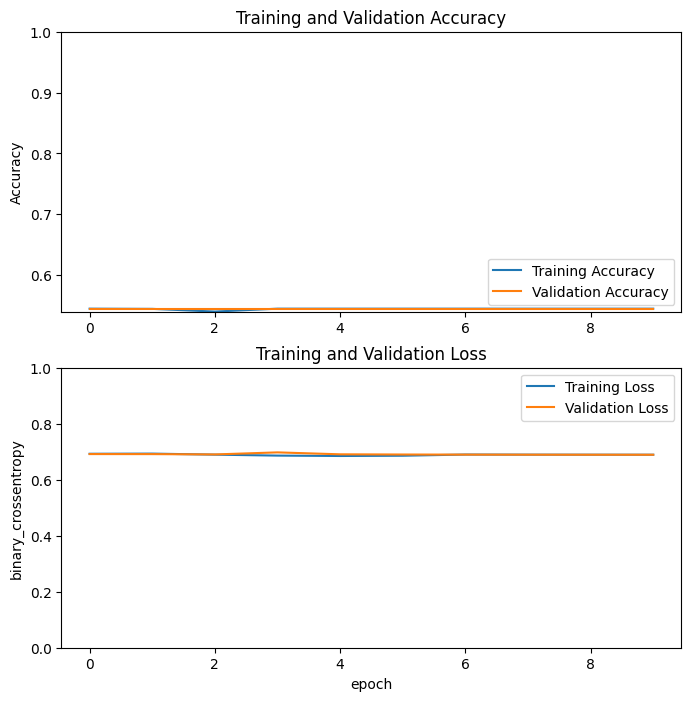

Epoch 10/25


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:681: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


99/99 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - accuracy: 0.5461 - loss: 0.6890 - val_accuracy: 0.5451 - val_loss: 0.6892
Epoch 11/25
99/99 ━━━━━━━━━━━━━━━━━━━━ 8s 71ms/step - accuracy: 0.5574 - loss: 0.6873 - val_accuracy: 0.5451 - val_loss: 0.6892
Epoch 12/25
99/99 ━━━━━━━━━━━━━━━━━━━━ 11s 80ms/step - accuracy: 0.5491 - loss: 0.6886 - val_accuracy: 0.5451 - val_loss: 0.6892
Epoch 13/25
99/99 ━━━━━━━━━━━━━━━━━━━━ 11s 91ms/step - accuracy: 0.5405 - loss: 0.6899 - val_accuracy: 0.5451 - val_loss: 0.6892
Epoch 14/25
99/99 ━━━━━━━━━━━━━━━━━━━━ 8s 69ms/step - accuracy: 0.5428 - loss: 0.6895 - val_accuracy: 0.5451 - val_loss: 0.6892
Epoch 15/25
99/99 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 0.5446 - loss: 0.6892 - val_accuracy: 0.5451 - val_loss: 0.6891
Epoch 16/25
99/99 ━━━━━━━━━━━━━━━━━━━━ 11s 80ms/step - accuracy: 0.5522 - loss: 0.6880 - val_accuracy: 0.5451 - val_loss: 0.6891
Epoch 17/25
99/99 ━━━━━━━━━━━━━━━━━━━━ 9s 91ms/step - accuracy: 0.5552 - loss: 0.6876 - val_accuracy: 0.5451 - 

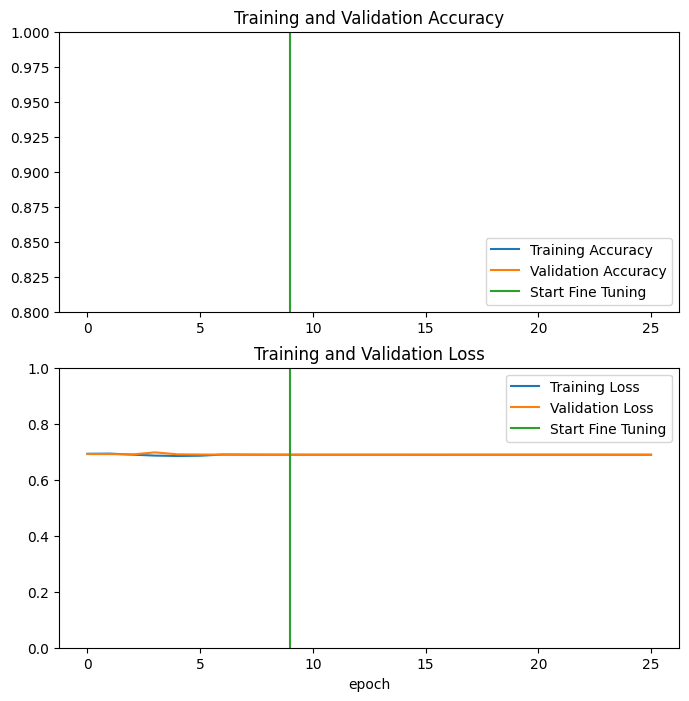

In [83]:
base_model.summary()
model.summary()


import tensorflow as tf
tf.keras.utils.plot_model(model, show_shapes=True)


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('binary_crossentropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


base_model.trainable = True
fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001/10),
              metrics=['accuracy'])

fine_tune_epochs = 15
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_features,
                         train_labels,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=(validation_features, validation_labels))


acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [84]:
loss, accuracy = model.evaluate(validation_features, validation_labels)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")
print(f"Validation Loss: {loss:.4f}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2166 - loss: 0.7423
Validation Accuracy: 54.51%
Validation Loss: 0.6891


# My Video

In [81]:
# import cv2

# def detect_smile(frame):
#     face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

#     gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
#     faces = face_cascade.detectMultiScale(gray, 1.1, 4)

#     for (x, y, w, h) in faces:
#         roi = frame[y:y+h, x:x+w]

#         # Resize to match input size of trained model
#         resized_roi = cv2.resize(roi, (224, 224))

#         # Normalize pixel values
#         normalized_roi = resized_roi.astype('float32') / 255.0

#         # Make predictions
#         prediction = model.predict(np.array([normalized_roi]))

#         smile_confidence = prediction[0][0]

#         # Draw rectangle around face and display confidence
#         cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
#         cv2.putText(frame, f"Smile Confidence: {smile_confidence:.2f}", (x, y-10),
#                     cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

#     return frame

# # Example usage with webcam
# cap = cv2.VideoCapture(0)

# while True:
#     ret, frame = cap.read()
#     if not ret:
#         break

#     result = detect_smile(frame)
#     cv2.imshow('Smile Detection', result)

#     if cv2.waitKey(1) & 0xFF == ord('q'):
#         break

# cv2.destroyAllWindows()

#---------------------------------------------------------------------------------
# # 6. Smile Detection with Webcam/Video

# # Define video capture
# cap = cv2.VideoCapture(0) # 0 for webcam, or specify video file path

# # Load the trained model
# model = load_model('your_trained_model.h5')

# # Function for smile detection on a frame
# def detect_smile(frame):
#   gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
#   faces = face_cascade.detectMultiScale(gray, 1.1, 4)
#   for (x, y, w, h) in faces:
#     face = frame[y:y + h, x:x + w]
#     face = cv2.resize(face, (224, 224))
#     face_input = preprocess_input(np.expand_dims(face, axis=0))
#     prediction = model.predict(face_input)
#     if prediction[0][0] > 0.5:
#       cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
#       cv2.putText(frame, 'Smile', (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
#     else:
#       cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 0, 255), 2)
#       cv2.putText(frame, 'No Smile', (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
#   return frame

# # Process video frames
# while True:
#   ret, frame = cap.read()
#   if not ret:
#     break
#   frame = detect_smile(frame)
#   cv2.imshow('Smile Detection', frame)
#   if cv2.waitKey(1) & 0xFF == ord('q'):
#     break

# # Release resources
# cap.release()
# cv2.destroyAllWindows()


# ---------------------------------------------------------------------------------------------------------

import argparse
import cv2,os

faceCascade = cv2.CascadeClassifier('xmls/haarcascade_frontalface_default.xml')
def detect_face(in_img):
    if in_img.ndim == 3:
        gray = cv2.cvtColor(in_img, cv2.COLOR_BGR2GRAY)
    elif in_img.ndim == 1:
        gray = in_img
    face_locations = faceCascade.detectMultiScale(
        gray,
        scaleFactor=1.1,
        minNeighbors=8,
        minSize=(55, 55),
        flags=cv2.CASCADE_SCALE_IMAGE
    )
    return face_locations


smileCascade = cv2.CascadeClassifier('xmls/haarcascade_smile.xml')
def detect_smile_face(in_img):
    if in_img.ndim == 3:
        gray = cv2.cvtColor(in_img, cv2.COLOR_BGR2GRAY)
    elif in_img.ndim == 1:
        gray = in_img
    smile_face_locations = smileCascade.detectMultiScale(
            gray,
            scaleFactor=1.16,
            minNeighbors=35,
            minSize=(25, 25),
            flags=cv2.CASCADE_SCALE_IMAGE
        )
    return smile_face_locations

def main():
    cap = cv2.VideoCapture(0, cv2.CAP_DSHOW)
    while True:
        res, frame = cap.read()

        if not res:
            print('err reading camera.')
            break

        draw_img = frame.copy()
        face_locations = detect_face(frame)
        for (x, y, w, h) in face_locations:
            cv2.rectangle(draw_img, (x, y), (x + w, y + h), (0, 225, 255), 2)
            face = frame[y:y + h, x:x + w]
            smile_face_locations = detect_smile_face(face)
            if len(smile_face_locations) > 0:
                cv2.rectangle(draw_img, (x, y), (x + w, y+ h), (0, 0, 255), 3)
                cv2.putText(draw_img, 'Smiling', (x, y - 7), 3, 1.2, (0, 255, 0), 1, cv2.LINE_AA)
        cv2.imshow('Real-Time Face Detect', draw_img)
        cv2.waitKey(1)
        if msvcrt.kbhit() and ord(msvcrt.getch()) == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()


if __name__ == '__main__':
    main()

err reading camera.
